# Food Vision
This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0.

## 1. Problem
Identifying the type of food given the image of a food-item.

## 2. Data

The images we're working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

The dataset **`food101`** is also available in TensorFlow Datasets: https://www.tensorflow.org/datasets/catalog/food101

## 3. Evaluation

Our goal is to beat the DeepFood paper.

They were able to achieve 77.4% top-1 accuracy on Food101 over 2-3 days of training.

So, our model needs to score an accuracy of more than 77.4%.

## 4. Features

Some information about the data:

* We're dealing with images (unstructured data), so it's probably best we use deep learning/transfer learning.
* There are 101 different types of food (this means there are 101 different classes).
* There are around 75,000+ images with labels in the training set.
* There are around 25,000+ images with labels in the test set.

## Check GPU
* Google Colab offers free GPUs, however, not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-9a67504d-7d1c-e664-7fc6-2671f23b91aa)


## Getting the required data

### Get helper functions

The script we've got available can be found on GitHub: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/SushanthJA/food-vision/master/extras/helper_functions.py

--2021-12-25 17:47:58--  https://raw.githubusercontent.com/SushanthJA/food-vision/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10438 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.19K  --.-KB/s    in 0s      

2021-12-25 17:47:58 (91.1 MB/s) - ‘helper_functions.py’ saved [10438/10438]



In [ ]:
# Import series of helper functions for the notebook
import helper_functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Use TensorFlow Datasets to Download Data

An overview of TensorFlow Datasets (TFDS): https://www.tensorflow.org/datasets/overview

In [ ]:
import tensorflow as tf

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [ ]:
# Load in the data (takes ~5 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompletePTF7F4/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompletePTF7F4/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Output info about the training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 41
  Class name (str form): french_onion_soup
  


In [ ]:
# What does the image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[168, 148, 123],
        [192, 172, 147],
        [200, 180, 155],
        ...,
        [179, 165, 139],
        [188, 172, 147],
        [154, 138, 113]],

       [[184, 164, 139],
        [209, 189, 164],
        [212, 192, 167],
        ...,
        [207, 193, 167],
        [218, 202, 177],
        [184, 168, 143]],

       [[186, 166, 139],
        [214, 194, 167],
        [211, 194, 168],
        ...,
        [207, 193, 167],
        [217, 203, 177],
        [180, 166, 140]],

       ...,

       [[206, 198, 179],
        [236, 228, 209],
        [230, 221, 204],
        ...,
        [226, 214, 200],
        [239, 227, 211],
        [203, 191, 175]],

       [[216, 208, 187],
        [239, 231, 210],
        [233, 225, 206],
        ...,
        [227, 215, 201],
        [237, 225, 209],
        [205, 193, 177]],

       [[173, 165, 144],
        [198, 190, 169],
        [204, 196, 177],
        ...,
        [197, 185, 17

In [ ]:
# What are the min and max values of the image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets


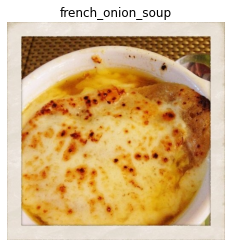

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Data Preprocessing

### Create preprocessing functions for our data

Neural Networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from the TensorFlow Datasets) comes like this.

So in order to get it ready for our neural network, we'll often have to write preprocessing functions and map it to our data.

What we know about our data:
* In `uint8` datatype.
* Comprised of all different size tensors (different sized images).
* Not scaled (the pixel values are between 0 & 255).

What models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`).
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size.
* Scaled (values between 0 & 1) also called normalized tensors generally perform better.

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.application, we don't need to rescale our data (these architectures have rescaling built-in).

This means our function needs to:
1. Reshape all our images to have the same shape, e.g. (224, 224, 3).
2. Convert the dtype of our image tensors from `uint8 ` to  `float32`.

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224, scale=False):
  """
  Converts image datatype from 'uint8' -> 'float32', scales the image 
  and reshapes image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  if scale:
    image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}..., \nShape:{preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[168 148 123]
  [192 172 147]
  [200 180 155]
  ...
  [179 165 139]
  [188 172 147]
  [154 138 113]]

 [[184 164 139]
  [209 189 164]
  [212 192 167]
  ...
  [207 193 167]
  [218 202 177]
  [184 168 143]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[194.12755 174.12755 149.12755]
  [204.66325 184.66325 159.66325]
  [198.20918 180.42348 158.85204]
  ...
  [200.12253 186.55106 160.97958]
  [204.22949 190.22949 164.22949]
  [195.14168 179.14168 154.14168]]

 [[197.10204 177.10204 150.10204]
  [202.5102  185.5102  159.5102 ]
  [209.96428 193.83673 169.47958]
  ...
  [201.301   187.72952 162.15805]
  [207.8622  193.8622  167.8622 ]
  [197.218   183.218   157.218  ]]]..., 
Shape:(224, 224, 3), 
Datatype: <dtype: 'float32'>


### Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this, go through the following guide: https://www.tensorflow.org/guide/data_performance

In [ ]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> This is basically telling TensorFlow, "map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure to prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch".

## Creating and fitting a Feature Extraction model

### Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be).
* ModelCheckpoint callback to save our model's progress after feature extraction.

In [ ]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "/content/drive/MyDrive/Food Vision/model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      mode="max",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1) # prints whether or not the model is being saved

### Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 datatypes to speed up model performance.

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

### Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't, you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Checking layer dtype policies (are we using mixed precision?)

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer.
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen).
* `layer.dtype`: the datatype a layer stores its variables in.
* `layer.dtype_policy`: the datatype policy a layer computes on its variables with.

In [ ]:
# Check the dtype policy attributes for layers in the base model
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

### Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the genral order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen).
2. Fine-tune some of the frozen layers.

In [ ]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="/content/drive/MyDrive/Food Vision/training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: /content/drive/MyDrive/Food Vision/training_logs/efficientnetb0_101_classes_all_data_feature_extract/20211216-121313


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8198 - accuracy: 0.5570
Epoch 00001: val_accuracy improved from -inf to 0.67542, saving model to /content/drive/MyDrive/Food Vision/model_checkpoints/cp.ckpt
2368/2368 [==============================] - 295s 113ms/step - loss: 1.8198 - accuracy: 0.5570 - val_loss: 1.2277 - val_accuracy: 0.6754
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2938 - accuracy: 0.6678
Epoch 00002: val_accuracy improved from 0.67542 to 0.70116, saving model to /content/drive/MyDrive/Food Vision/model_checkpoints/cp.ckpt
2368/2368 [==============================] - 260s 109ms/step - loss: 1.2939 - accuracy: 0.6678 - val_loss: 1.1156 - val_accuracy: 0.7012
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1432 - accuracy: 0.7021
Epoch 00003: val_accuracy improved from 0.70116 to 0.70693, saving model to /content/drive/MyDrive/Food Vision/model_checkpoints/cp.ckpt
2368/2368 [================

In [ ]:
# Evaluate model on the whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 82s 103ms/step - loss: 1.0851 - accuracy: 0.7084


[1.0850626230239868, 0.7083564400672913]

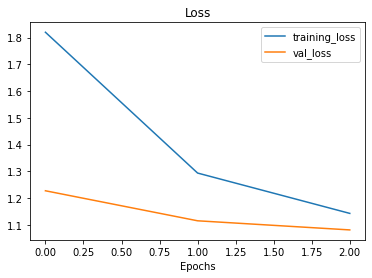

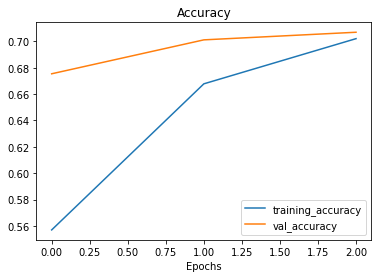

In [ ]:
# Plot loss curves
plot_loss_curves(history_101_food_classes_feature_extract)

As the curves are converging pretty well, we can safely suggest that our feature extraction model is training properly.

### Load and evaluate checkpoint weights

We can load in and evaluate our model's checkpoints by:

1. Cloning our model using `tf.keras.models.clone_model()` to make a copy of our feature extraction model with reset weights.
2. Calling the `load_weights()` method on our cloned model passing it the path to where our checkpointed weights are stored.
3. Calling `evaluate()` on the cloned model with loaded weights.

In the case you fine-tune your feature extraction model and find it doesn't offer any improvements, you can always revert back to the checkpointed version of your model.

In [ ]:
# Clone the model we created (this resets all weights)
cloned_feature_extract_model = tf.keras.models.clone_model(model)
cloned_feature_extract_model.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Where are our checkpoints stored?
checkpoint_path

'/content/drive/MyDrive/Food Vision/model_checkpoints/cp.ckpt'

In [ ]:
!ls /content/drive/MyDrive/Food\ Vision/model_checkpoints

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [ ]:
# Load checkpointed weights into cloned model
cloned_feature_extract_model.load_weights(checkpoint_path)

In [ ]:
# Compile cloned_model (with same parameters as original model)
cloned_feature_extract_model.compile(loss="sparse_categorical_crossentropy",
                                     optimizer=tf.keras.optimizers.Adam(),
                                     metrics=["accuracy"])

In [ ]:
# Evaluate cloned model with loaded weights (should be swame score as the trained model)
results_cloned_feature_extract_model = cloned_feature_extract_model.evaluate(test_data)

In [ ]:
# Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
np.isclose(np.array(results_feature_extract_model), np.array(results_cloned_feature_extract_model)).all()

Cloning the model preserves `dtype_policy's` of layers (but doesn't preserve weights) so if we wanted to continue fine-tuning with the cloned model, we could and it would still use the mixed precision dtype policy.

### Saving the whole model to a file

In [ ]:
save_dir = "/content/drive/MyDrive/Food Vision/saved_models/efficientnetb0_feature_extract_model"
model.save(save_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food Vision/saved_models/efficientnetb0_feature_extract_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food Vision/saved_models/efficientnetb0_feature_extract_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Load model previously saved above
loaded_feature_extract_model = tf.keras.models.load_model(save_dir)

In [ ]:
loaded_feature_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_feature_extract_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_feature_extract_model = loaded_feature_extract_model.evaluate(test_data)
results_loaded_feature_extract_model

790/790 [==============================] - 80s 97ms/step - loss: 1.0851 - accuracy: 0.7084


[1.0850632190704346, 0.7083564400672913]

In [ ]:
# Compare the results
np.isclose(np.array(results_feature_extract_model), np.array(results_loaded_feature_extract_model)).all()

True

Looks like our loaded model is performing as it should!

## Creating and fitting a model for Fine-Tuning

### Preparing our model's layers for fine-tuning

Our feature-extraction model is showing some great promise after three epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

Our goal is beating the DeepFood paper.

They were able to achieve 77.4% top-1 accuracy on Food101 after training.

To start, let's load in our saved model.

In [ ]:
loaded_model = tf.keras.models.load_model(save_dir)

In [ ]:
for layer in loaded_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed

It looks like each layer in our base model is trainable (unfrozen), and every layer which should be using the dtype policy "mixed_policy16" is using it.

Since we've got so much data (750 images x 101 training classes = 75750 training images), let's keep all of our base model's layers unfrozen.

> Note: If you've got a small amount of data (less than 100 images per class), you may want to only unfreeze and fine-tune a small number of layers in the base model at a time. Otherwise, you risk overfitting.

### Adding a couple more callbacks

1. `EarlyStopping` callback to stop training if model's `val_loss` doesn't improve along with `ModelCheckpoint` callback to save best model during fine-tuning.

Using the `EarlyStopping` callback combined with the `ModelCheckpoint `callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

2. `ReduceLROnPlateau` callback.

As training goes on and our model gets closer and closer to it's ideal performance (also called convergence), we want the amount it learns to be less and less.

To do this we'll create an instance of the `ReduceLROnPlateau` callback to monitor the validation loss.

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. 0.001 to 0.0002).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to 1e-7.

In [ ]:
# Setup EarlyStopping callback to stop training if the model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

checkpoint_path = "/content/drive/MyDrive/Food Vision/model_checkpoints/efficientnetb0_fine_tune_checkpoints"
# Create ModelCheckpoint callback to save the best mode during fine-tuning
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True)

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when lr goes down
                                                 min_lr=1e-7)

Now before we start training, let's recompile the model

In [ ]:
loaded_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #10x lower learning rate than default for fine-tuning
                     metrics=["accuracy"])

### Fit the fine-tuning model
Now let's fit our model on all of the data

In [ ]:
history_101_classes_fine_tune = loaded_model.fit(train_data,
                                                 epochs=100,
                                                 steps_per_epoch=len(train_data),
                                                 validation_data=test_data,
                                                 validation_steps=(0.15 * len(test_data)),
                                                 callbacks=[create_tensorboard_callback(dir_name="/content/drive/MyDrive/Food Vision/training_logs",
                                                                                        experiment_name="efficientnetb0_101_classes_all_data_fine-tune"),
                                                            model_checkpoint,
                                                            early_stopping,
                                                            reduce_lr])

Saving TensorBoard log files to: /content/drive/MyDrive/Food Vision/training_logs/efficientnetb0_101_classes_all_data_fine-tune/20211216-123327


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9247 - accuracy: 0.7513INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food Vision/model_checkpoints/efficientnetb0_fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food Vision/model_checkpoints/efficientnetb0_fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 1240s 509ms/step - loss: 0.9247 - accuracy: 0.7513 - val_loss: 0.8208 - val_accuracy: 0.7752 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5780 - accuracy: 0.8392INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food Vision/model_checkpoints/efficientnetb0_fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food Vision/model_checkpoints/efficientnetb0_fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 1195s 504ms/step - loss: 0.5780 - accuracy: 0.8392 - val_loss: 0.7977 - val_accuracy: 0.7791 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 1128s 475ms/step - loss: 0.3303 - accuracy: 0.9062 - val_loss: 0.8703 - val_accuracy: 0.7823 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.9486
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 1123s 473ms/step - loss: 0.1742 - accuracy: 0.9486 - val_loss: 0.9907 - val_accuracy: 0.7847 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 1119s 472ms/step - loss: 0.0346 - accuracy: 0.9917 - val_loss: 1.0409 - val_accuracy: 0.8036 - lr: 2.0000e-05


Unfortunately due to the randomness in allocation of GPUs by Google Colab, we are assigned a `Tesla K80`, which doesn't support `Mixed Precision Training`. That's the reason behind higher training times.

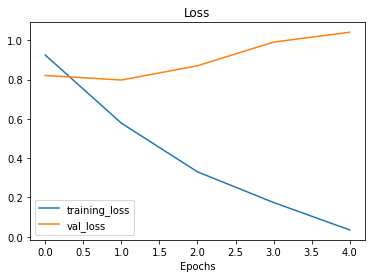

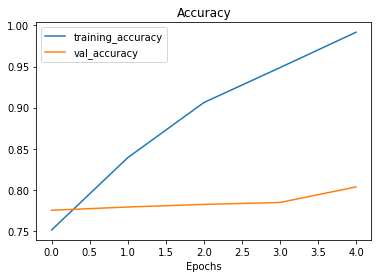

In [ ]:
# Plot loss curves of our fine-tuned model
plot_loss_curves(history_101_classes_fine_tune)

As we can see from the above curves, the `validation loss` is first decreasing and slightly increasing after the second epoch when the `training loss` is strictly decreasing (which suggests that the model is slightly overfitting at every epoch after the second one), but also the model's `validation accuracy` increases slightly after every epoch along with the `training accuracy` which is what we want as we're considering **validation accuracy as our evaluation metric** to beat the DeepFood paper.

Let's make sure we save our model before we start evaluating it.

In [ ]:
# Saving our fine-tuned model
loaded_model.save("/content/drive/MyDrive/Food Vision/saved_models/efficientnetb0_food101_fine_tuned_mixed_precision_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food Vision/saved_models/efficientnetb0_food101_fine_tuned_mixed_precision_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food Vision/saved_models/efficientnetb0_food101_fine_tuned_mixed_precision_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


### View training results on TensorBoard

Uploading and inspecting our model's training logs on TensorBoard.dev

In [ ]:
!tensorboard dev upload --logdir /content/drive/MyDrive/Food\ Vision/training_logs/ \
  --name "Fine-Tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Lwa6YYJjRgmYBEU9xSKobQ/

[2021-12-16T15:13:25] Started scanning logdir.
[2021-12-16T15:13:27] Total uploaded: 48 scalars, 0 tensors, 2 binary objects (2.0 MB)
[2021-12-16T15:13:27] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/Lwa6YYJjRgmYBEU9xSKobQ/


## Evaluating our fine-tuned model

In [ ]:
# Evaluating our fine-tuned model on the test data
results_fine_tuned_model = loaded_model.evaluate(test_data)
results_fine_tuned_model

790/790 [==============================] - 80s 100ms/step - loss: 1.0408 - accuracy: 0.8009


[1.0407987833023071, 0.8008713126182556]

As we can see from the above result, our model has outperformed the model constructed by the authors of the DeepFood paper (whose accuracy was 77.4%), with our model scoring an accuracy of **`80.08%`** on the test_data.

### Making predictions with our fine-tuned model

We had set `shuffle_data=True` while importing the data.

This operation has shuffled the test_data files too.

So now we have to re-import the test_data unshuffled to make predictions on it.

In [ ]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Batching and preparing only the test data for evaluation...

In [ ]:
# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
loaded_fine_tune_model = tf.keras.models.load_model("/content/drive/MyDrive/Food Vision/saved_models/efficientnetb0_food101_fine_tuned_mixed_precision_model")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
# Evaluate the newly loaded model
results_loaded_fine_tune_model = loaded_fine_tune_model.evaluate(test_data)
results_loaded_fine_tune_model

790/790 [==============================] - 134s 143ms/step - loss: 1.0408 - accuracy: 0.8009


[1.0407991409301758, 0.8008713126182556]

In [ ]:
pred_probs = loaded_fine_tune_model.predict(test_data, verbose=1)

790/790 [==============================] - 97s 120ms/step


In [ ]:
# How many predictions are there?
len(pred_probs)

25250

In [ ]:
# What's the shape of our predicitons?
pred_probs.shape

(25250, 101)

In [ ]:
pred_probs[:10]

array([[2.71540557e-07, 7.72623813e-15, 7.06446240e-13, ...,
        5.84783610e-10, 3.92370733e-14, 3.10761720e-06],
       [2.73494612e-11, 6.71237019e-15, 2.22283170e-13, ...,
        2.10011485e-14, 1.27722721e-09, 1.37728896e-14],
       [2.04442348e-11, 1.97024078e-10, 7.21769758e-13, ...,
        3.74449197e-13, 3.64457908e-11, 1.36967835e-12],
       ...,
       [1.10491802e-12, 1.18469641e-16, 1.71390849e-15, ...,
        1.07415224e-18, 2.72732565e-17, 2.96760094e-14],
       [7.81508530e-17, 2.49409410e-14, 1.14187953e-14, ...,
        5.42474416e-16, 3.79160738e-08, 7.89295688e-16],
       [4.70131226e-02, 1.49768409e-11, 4.63960901e-12, ...,
        3.23602872e-05, 1.05915402e-16, 9.50761020e-01]], dtype=float32)

In [ ]:
pred_probs[0].argmax()

29

In [ ]:
# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

In [ ]:
len(test_data)

790

In [ ]:
y_labels = []
y_images = []

i = 0
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy()) # append the label index
  y_images.append("test_img_" + str(i))
  i += 1

y_labels[:10] # check what they look like (unshuffled)

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
y_images[:10]

['test_img_0',
 'test_img_1',
 'test_img_2',
 'test_img_3',
 'test_img_4',
 'test_img_5',
 'test_img_6',
 'test_img_7',
 'test_img_8',
 'test_img_9']

In [ ]:
len(y_labels), len(y_images)

(25250, 25250)

### Evaluating our model's predictions

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.8008712871287129

In [ ]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(results_loaded_fine_tune_model, sklearn_accuracy, atol=0.25)} | Difference: {results_loaded_fine_tune_model - sklearn_accuracy}")

Close? [ True  True] | Difference: [2.39927854e-01 2.54895427e-08]


It looks like our `pred_classes` array and `y_labels` arrays are in the right orders.

How about we get a little bit more visual with a confusion matrix?

### Confusion Matrix


Using `make_confusion_matrix()` function pre-defined in the `helper_functions.py` file.

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

The below image of confusion_matrix can be found in the extras folder.

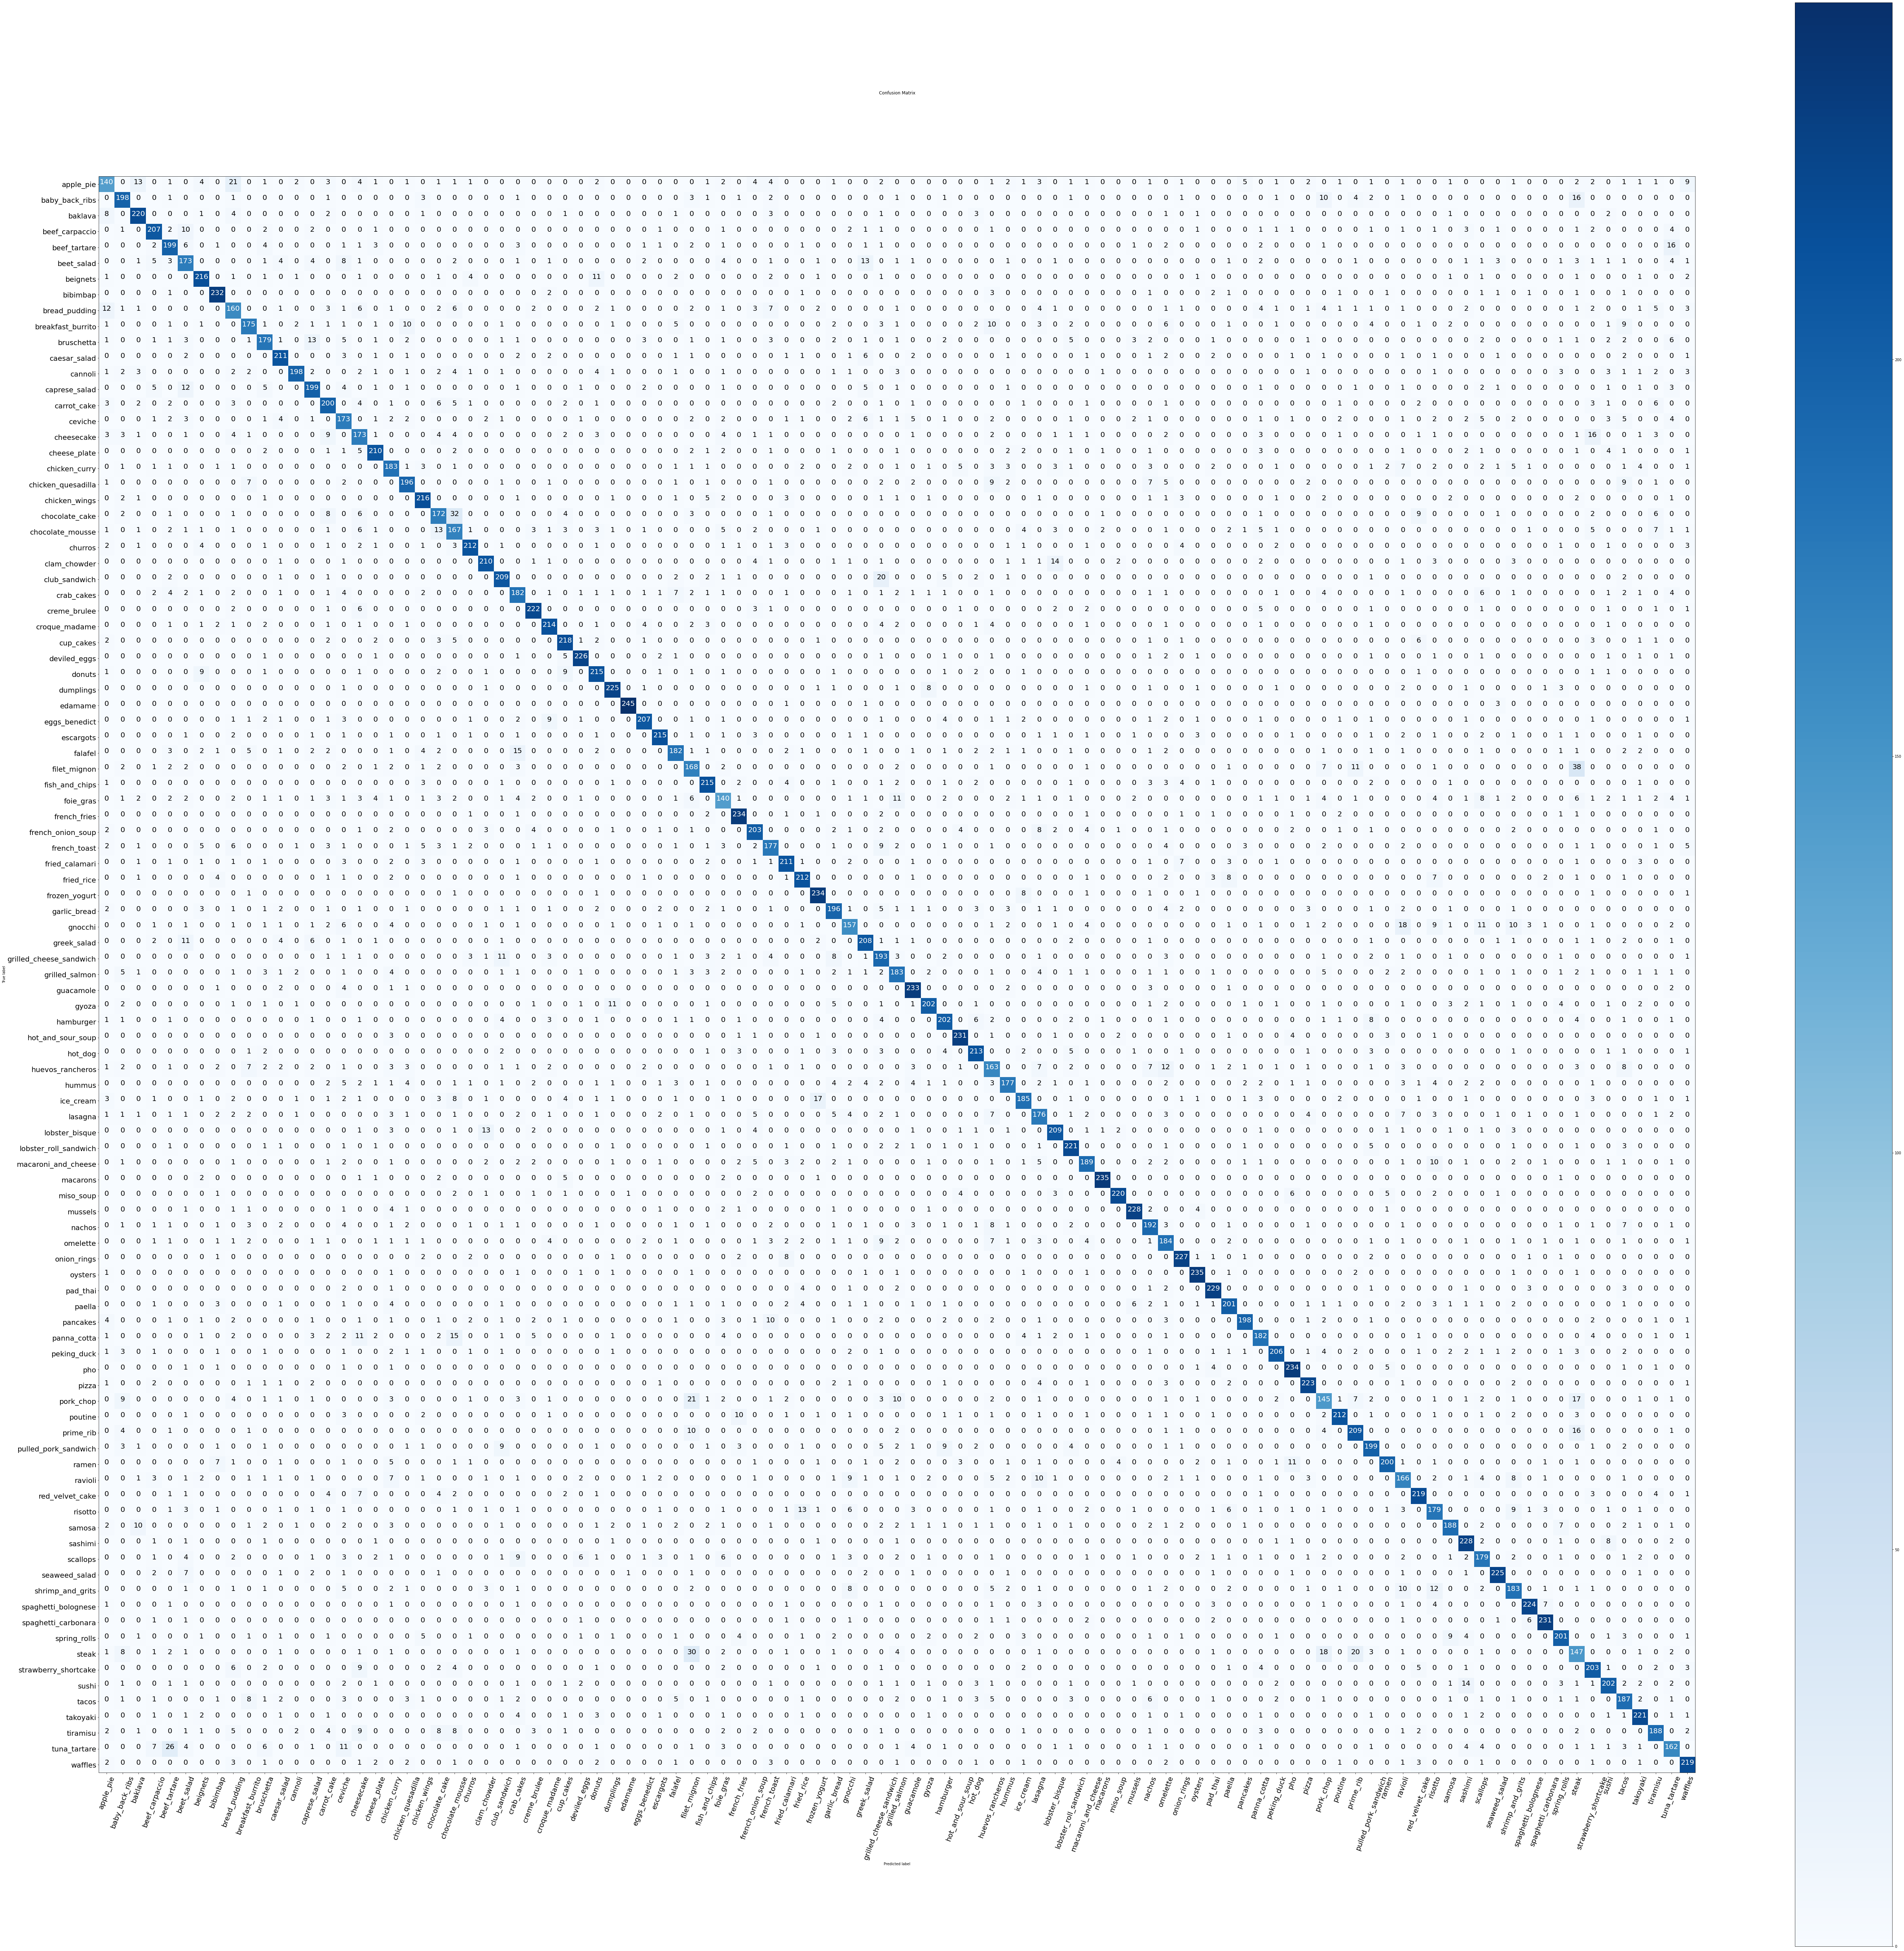

In [ ]:
# Plot a confusion matrix with all the 25,250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=False)

The good news is, the majority of the predictions are right down the top left to bottom right diagonal, meaning they're correct.

It looks like the model gets most confused on classes which look visually similar, such as predicting `steak` for instances of `filet_mignon` and vice-versa.

### Classification Report

Since we're working on a classification problem, we can further evaluate our model's predictions using Scikit-Learn's classification_report() function.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.68      0.56      0.61       250
           1       0.78      0.79      0.78       250
           2       0.83      0.88      0.85       250
           3       0.82      0.83      0.82       250
           4       0.73      0.80      0.76       250
           5       0.66      0.69      0.68       250
           6       0.83      0.86      0.85       250
           7       0.88      0.93      0.90       250
           8       0.63      0.64      0.64       250
           9       0.79      0.70      0.74       250
          10       0.76      0.72      0.74       250
          11       0.83      0.84      0.84       250
          12       0.93      0.79      0.86       250
          13       0.80      0.80      0.80       250
          14       0.75      0.80      0.77       250
          15       0.61      0.69      0.65       250
          16       0.64      0.69      0.67       250
          17       0.86    

The `classification_report()` outputs the precision, recall and f1-score's per class.

A reminder:

* **Precision** - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
* **Recall** - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
* **F1 score** - Combines precision and recall into one metric. 1 is best, 0 is worst.
The above output is helpful but with so many classes, it's a bit hard to understand.

Let's see if we make it easier with the help of a visualization.

First, we'll get the output of `classification_report()` as a dictionary by setting output_dict=True.

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.6140350877192982,
  'precision': 0.6796116504854369,
  'recall': 0.56,
  'support': 250},
 '1': {'f1-score': 0.7841584158415841,
  'precision': 0.7764705882352941,
  'recall': 0.792,
  'support': 250},
 '10': {'f1-score': 0.7351129363449691,
  'precision': 0.7552742616033755,
  'recall': 0.716,
  'support': 250},
 '100': {'f1-score': 0.8455598455598455,
  'precision': 0.8171641791044776,
  'recall': 0.876,
  'support': 250},
 '11': {'f1-score': 0.8373015873015872,
  'precision': 0.8307086614173228,
  'recall': 0.844,
  'support': 250},
 '12': {'f1-score': 0.8571428571428572,
  'precision': 0.9339622641509434,
  'recall': 0.792,
  'support': 250},
 '13': {'f1-score': 0.796,
  'precision': 0.796,
  'recall': 0.796,
  'support': 250},
 '14': {'f1-score': 0.7736943907156673,
  'precision': 0.7490636704119851,
  'recall': 0.8,
  'support': 250},
 '15': {'f1-score': 0.6467289719626169,
  'precision': 0.6070175438596491,
  'recall': 0.692,
  'support': 250},
 '16': {'f1-s

There's still a fair few values here, how about we narrow down?

Since the f1-score combines precision and recall in one metric, let's focus on that.

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.6140350877192982,
 'baby_back_ribs': 0.7841584158415841,
 'baklava': 0.8543689320388349,
 'beef_carpaccio': 0.8230616302186878,
 'beef_tartare': 0.7624521072796934,
 'beet_salad': 0.6771037181996086,
 'beignets': 0.8470588235294119,
 'bibimbap': 0.9009708737864077,
 'bread_pudding': 0.6361829025844931,
 'breakfast_burrito': 0.7415254237288137,
 'bruschetta': 0.7351129363449691,
 'caesar_salad': 0.8373015873015872,
 'cannoli': 0.8571428571428572,
 'caprese_salad': 0.796,
 'carrot_cake': 0.7736943907156673,
 'ceviche': 0.6467289719626169,
 'cheese_plate': 0.8484848484848485,
 'cheesecake': 0.6653846153846155,
 'chicken_curry': 0.7176470588235294,
 'chicken_quesadilla': 0.801635991820041,
 'chicken_wings': 0.8520710059171598,
 'chocolate_cake': 0.7020408163265307,
 'chocolate_mousse': 0.6290018832391715,
 'churros': 0.8688524590163934,
 'clam_chowder': 0.8553971486761711,
 'club_sandwich': 0.8260869565217391,
 'crab_cakes': 0.7193675889328064,
 'creme_brulee': 0.8827037773

It seems like our dictionary is ordered by the class names. However, I think if we're trying to visualize different scores, it might look nicer if they were in some kind of order.

How about we turn our `class_f1_scores` dictionary into a pandas DataFrame and sort it in ascending fashion (best to worst)?

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_name  f1-score
33              edamame  0.985915
63             macarons  0.955285
91  spaghetti_carbonara  0.924000
69              oysters  0.923379
54    hot_and_sour_soup  0.922156
..                  ...       ...
22     chocolate_mousse  0.629002
0             apple_pie  0.614035
77            pork_chop  0.607966
39            foie_gras  0.599572
93                steak  0.547486

[101 rows x 2 columns]

Let's visualize it with a horizontal bar chart.

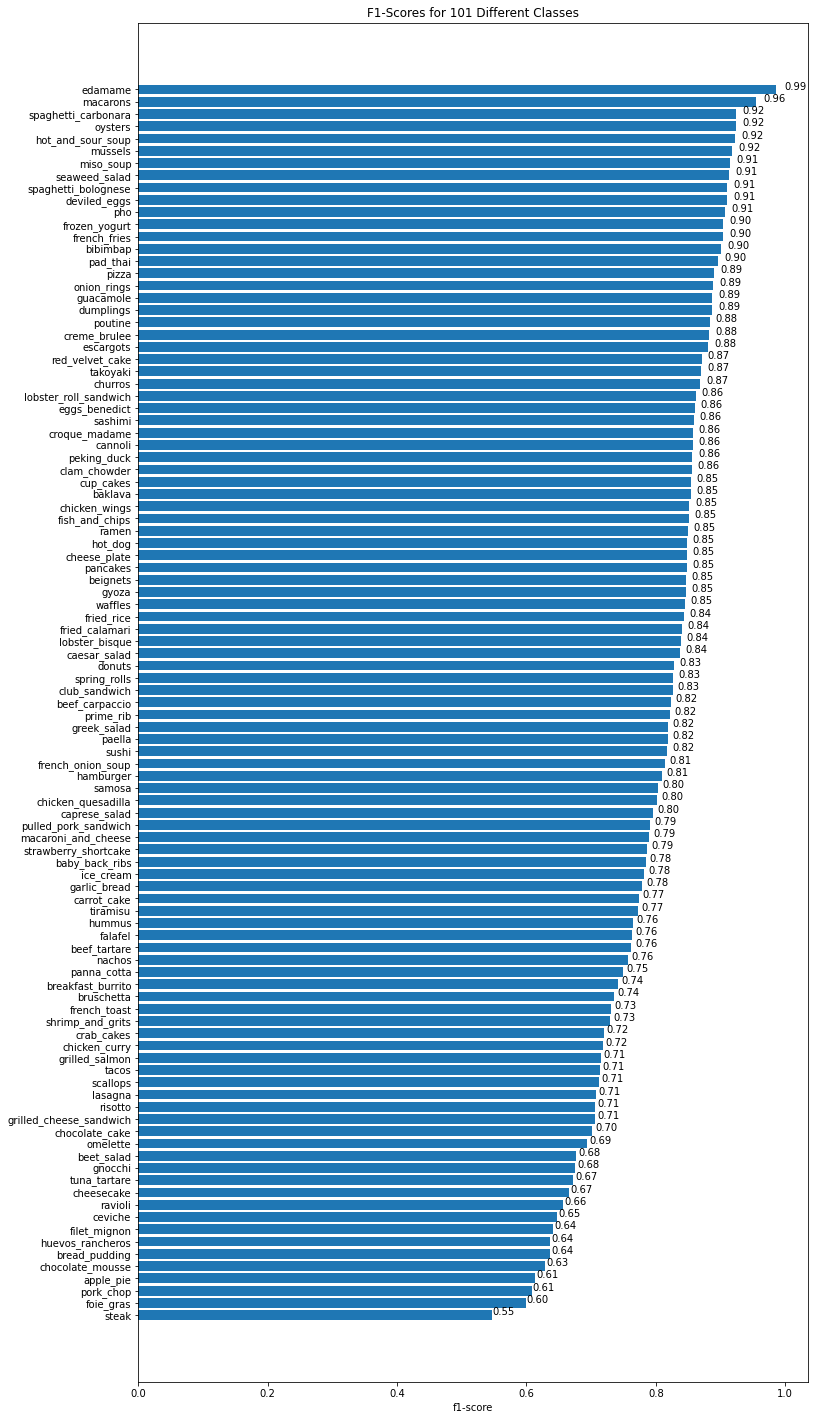

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 101 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

It seems like our model performs fairly poorly on classes like `steak` and `foie_gras` while for classes like `edamame` and `macarons` the performance is quite outstanding.

### Visualizing predictions on test images

1. Load a few random images from the test dataset.
2. Get the model's predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

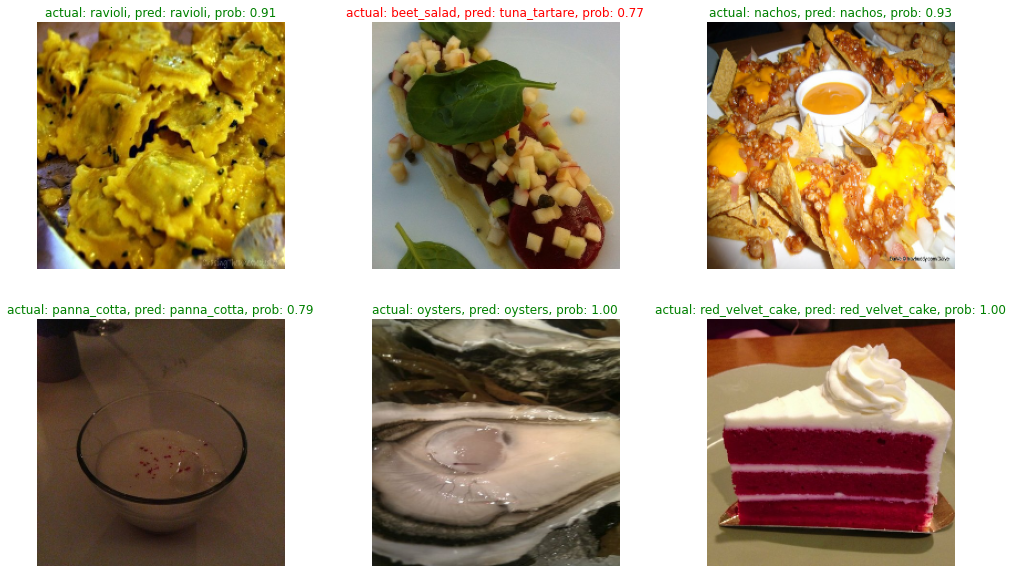

In [ ]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(17, 10))
for i in range(6):
  # Choose a random image and its prediction
  index = random.randint(0, 25250)
  pred_class = pred_classes[index]
  actual_class = y_labels[index]
  rand_img = []

  for j, (img, lab) in enumerate(test_data.unbatch()):
    if j == index:
      rand_img.append(img)
      break

  # Plot the image(s)
  plt.subplot(2, 3, i+1)
  plt.imshow((tf.squeeze(rand_img))/255.)
  if actual_class == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_names[actual_class]}, pred: {class_names[pred_class]}, prob: {pred_probs[index].max():.2f}", c=title_color)
  plt.axis(False);

### Finding the most wrong predictions

It's a good idea to go through at least 100+ random instances of our model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These most wrong predictions can help to give further insight into our model's performance.

In [ ]:
# Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_name": y_images,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_name  y_true  ...     y_true_classname     y_pred_classname
0  test_img_0      29  ...            cup_cakes            cup_cakes
1  test_img_1      81  ...                ramen                ramen
2  test_img_2      91  ...  spaghetti_carbonara  spaghetti_carbonara
3  test_img_3      53  ...            hamburger            hamburger
4  test_img_4      97  ...             takoyaki             takoyaki

[5 rows x 6 columns]

In [ ]:
# Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_name  y_true  ...     y_pred_classname  pred_correct
0  test_img_0      29  ...            cup_cakes          True
1  test_img_1      81  ...                ramen          True
2  test_img_2      91  ...  spaghetti_carbonara          True
3  test_img_3      53  ...            hamburger          True
4  test_img_4      97  ...             takoyaki          True

[5 rows x 7 columns]

In [ ]:
# Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_name  y_true  ...   y_pred_classname  pred_correct
9735    test_img_9735      87  ...       deviled_eggs         False
1113    test_img_1113      72  ...           omelette         False
15437  test_img_15437      56  ...             nachos         False
900      test_img_900      14  ...          cup_cakes         False
13884  test_img_13884      46  ...         bruschetta         False
21838  test_img_21838       8  ...  french_onion_soup         False
6434    test_img_6434      37  ...     chocolate_cake         False
7455    test_img_7455      43  ...        onion_rings         False
3182    test_img_3182      21  ...    red_velvet_cake         False
1420    test_img_1420      93  ...          prime_rib         False
16129  test_img_16129      65  ...            oysters         False
19665  test_img_19665      19  ...  breakfast_burrito         False
217      test_img_217      44  ...             paella         False
22323  test_img_22323      64  ...  hot_and_sour_soup         False
22358  test_img_22358      34  ...            sashimi         False
359      test_img_359      99  ...       beef_tartare         False
3891    test_img_3891       0  ...             donuts         False
25131  test_img_25131      71  ...           pad_thai         False
20931  test_img_20931      93  ...          foie_gras         False
6614    test_img_6614      93  ...     baby_back_ribs         False

[20 rows x 7 columns]

We can see our model's top 100 wrong predictions in the above DataFrame.

It might be easier if we visualize them.

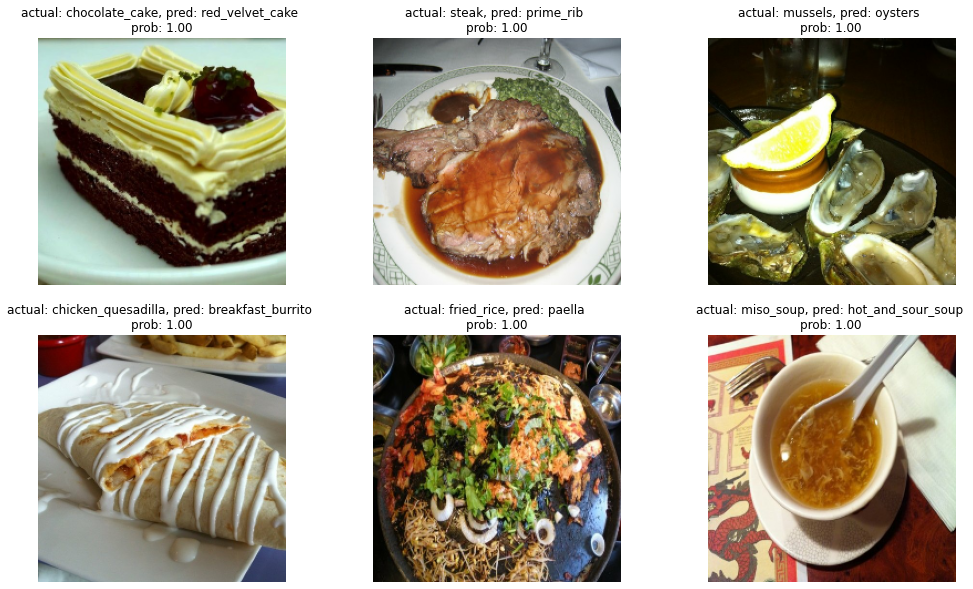

In [ ]:
# Visualize some of the most wrong examples
images_to_view = 6
start_index = 8 # change the start index to view more
plt.figure(figsize=(17, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  index = top_100_wrong.index[start_index+i]
  plt.subplot(2, 3, i+1)
  image = []
  for j, (img, lab) in enumerate(test_data.unbatch()):
    if j == index:
      image.append(img)
      break
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow((tf.squeeze(image))/255.)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

After going through enough random samples, it starts to become clear that our model tends to make far worse predictions on classes which are visually similar such as `chocolate_cake` getting mistaken as `red_velvet_cake` and `steak` as `prime_rib` etc.

## Predicting on our own data

So far we've visualized some our model's predictions from the test dataset but it's time for the real test: using our model to make predictions on our own custom images of food.

In [ ]:
import os
from helper_functions import load_and_prep_image

# Get custom food images filepaths
custom_path = "/content/drive/MyDrive/Food Vision/custom_food_images/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths

['/content/drive/MyDrive/Food Vision/custom_food_images/pizza-dad.jpeg',
 '/content/drive/MyDrive/Food Vision/custom_food_images/steak.jpeg',
 '/content/drive/MyDrive/Food Vision/custom_food_images/ramen.jpeg',
 '/content/drive/MyDrive/Food Vision/custom_food_images/chicken_wings.jpeg',
 '/content/drive/MyDrive/Food Vision/custom_food_images/hamburger.jpeg',
 '/content/drive/MyDrive/Food Vision/custom_food_images/sushi.jpeg']

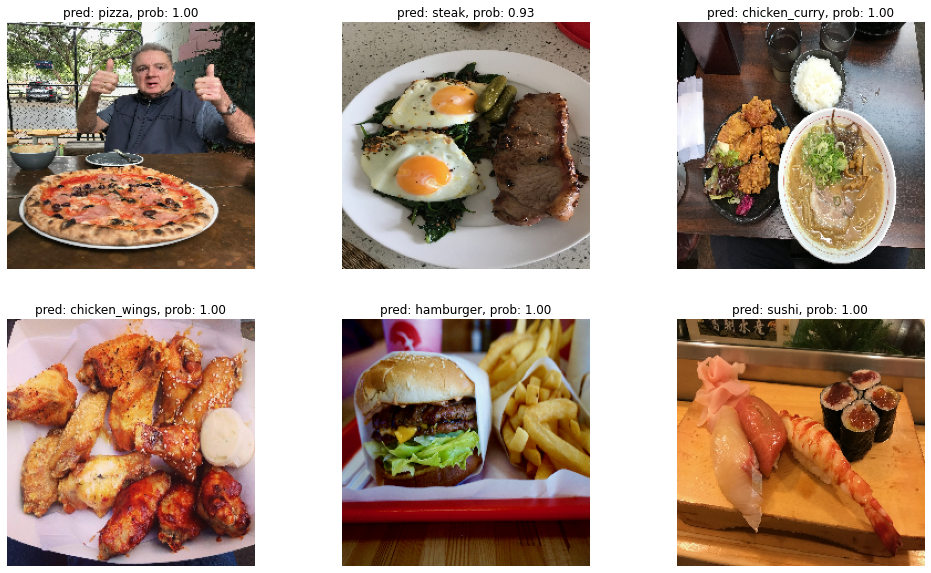

In [ ]:
# Make predictions on custom food images
plt.figure(figsize=(17, 10))

i = 1
for img in custom_image_paths:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  tf.cast(img, tf.float32) # return float_32 image

  pred_prob = loaded_fine_tune_model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  
  # Plot the image with appropriate annotations
  plt.subplot(2, 3, i)
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)
  i += 1

## Conclusion

We have achieved the goal that we had set out to achieve, i.e, beating the DeepFood paper.

From the results evaluated, we can confirm that our model has outperformed the model built by the authors of `DeepFood` paper (whose accuracy was **77.4%**), with our model scoring an accuracy of **80.08%**.

This model can still be improved by better hyper-parameter tuning.